In [ ]:
!pip install openmeteo-requests requests-cache retry-requests numpy pandas keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.0 MB/s eta 0:00:00


In [ ]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
from datetime import timedelta
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

In [ ]:
yesterday = pd.to_datetime("today").date() - timedelta(days=1)


# Fetch weather stats data
weather_url = "https://archive-api.open-meteo.com/v1/archive"
weather_params = {
    "latitude": 59.91,
    "longitude": 10.75,
    "start_date": "2010-01-01",
    "end_date": yesterday,
    "daily": ["temperature_2m_max", "temperature_2m_min", "precipitation_hours", "wind_speed_10m_max", "wind_gusts_10m_max"],
    "timezone": "GMT"
}
weather_responses = openmeteo.weather_api(weather_url, params=weather_params)
weather_response = weather_responses[0]

daily = weather_response.Daily()
daily_data_weather = {
     "date": pd.date_range(
        start=pd.to_datetime(daily.Time(), unit="s", utc=True).tz_localize(None),  # Remove timezone here
        end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True).tz_localize(None),  # Remove timezone here
        freq=pd.Timedelta(seconds=daily.Interval()),
        inclusive="left"
    ),
    "temperature_2m_max": daily.Variables(0).ValuesAsNumpy(),
    "temperature_2m_min": daily.Variables(1).ValuesAsNumpy(),
    "precipitation_hours": daily.Variables(2).ValuesAsNumpy(),
    "wind_speed_10m_max": daily.Variables(3).ValuesAsNumpy(),
    "wind_gusts_10m_max": daily.Variables(4).ValuesAsNumpy()
}

weather_dataframe = pd.DataFrame(data=daily_data_weather)

In [ ]:
# Fetch river discharge data
discharge_url = "https://flood-api.open-meteo.com/v1/flood"
discharge_params = {
    "latitude": 59.91,
    "longitude": 10.75,
    "daily": "river_discharge",
    "start_date": "2010-01-01",
    "end_date": yesterday
}
discharge_responses = openmeteo.weather_api(discharge_url, params=discharge_params)
discharge_response = discharge_responses[0]

daily_discharge = discharge_response.Daily()
daily_data_discharge = {
     "date": pd.date_range(
        start=pd.to_datetime(daily.Time(), unit="s", utc=True).tz_localize(None),
        end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True).tz_localize(None),
        freq=pd.Timedelta(seconds=daily.Interval()),
        inclusive="left"
    ),
    "river_discharge": daily_discharge.Variables(0).ValuesAsNumpy()
}

discharge_dataframe = pd.DataFrame(daily_data_discharge)

In [ ]:
combined_df = pd.merge(weather_dataframe, discharge_dataframe, on="date", how="inner")

combined_df['date'] = pd.to_datetime(combined_df['date']).dt.tz_localize(None)
combined_df.set_index('date', inplace=True)

In [ ]:
print(combined_df)
print(combined_df.columns)

            temperature_2m_max  temperature_2m_min  precipitation_hours  \
date                                                                      
2010-01-01           -8.507999          -10.957999                  2.0   
2010-01-02          -10.158000          -18.408001                  0.0   
2010-01-03          -16.858000          -20.008001                  0.0   
2010-01-04          -16.108000          -18.458000                  0.0   
2010-01-05          -15.007999          -20.158001                  2.0   
...                        ...                 ...                  ...   
2024-10-22           12.201500            6.201500                  0.0   
2024-10-23           11.051500            5.151500                  0.0   
2024-10-24           12.801500            6.901500                  0.0   
2024-10-25           10.701500            5.101500                  0.0   
2024-10-26            4.651500            4.651500                  0.0   

            wind_speed_1

# Normal LSTM

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 27s 337ms/step - loss: 0.0574 - val_loss: 0.0228
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 33s 223ms/step - loss: 0.0242 - val_loss: 0.0219
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 15s 231ms/step - loss: 0.0232 - val_loss: 0.0216
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 20s 224ms/step - loss: 0.0226 - val_loss: 0.0212
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 15s 222ms/step - loss: 0.0220 - val_loss: 0.0209
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 21s 235ms/step - loss: 0.0209 - val_loss: 0.0202
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 20s 226ms/step - loss: 0.0213 - val_loss: 0.0198
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 15s 223ms/step - loss: 0.0203 - val_loss: 0.0195
Epoch 9/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 21s 235ms/step - loss: 0.0202 - val_loss: 0.0195
Epoch 10/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 20s 225ms/step - loss: 0.0196 - val_loss: 0.0191
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step
Test MAPE: 1141787125088256.0


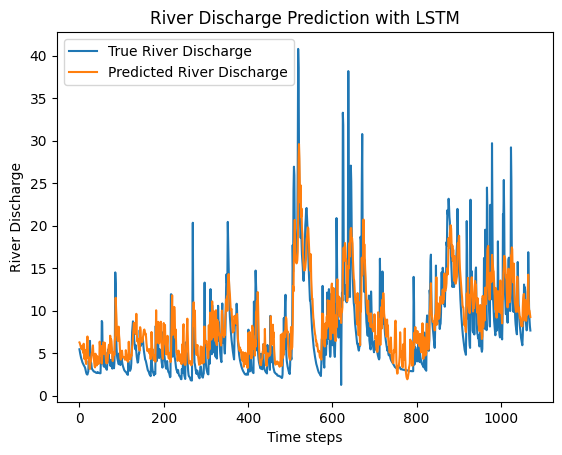

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_percentage_error

# Select the features for training
features = ['temperature_2m_max', 'temperature_2m_min',
            'precipitation_hours', 'wind_speed_10m_max',
            'wind_gusts_10m_max', 'river_discharge']

data = combined_df[features].values

# Scaling the data (LSTMs perform better with scaled data)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences and corresponding labels (next step prediction)
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])  # predicting the next time step
    return np.array(X), np.array(y)

time_steps = 60  # The number of previous time steps to use for prediction
X, y = create_sequences(scaled_data, time_steps)

# Split the data into training and testing sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # To prevent overfitting
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(units=X_train.shape[2]))  # Output layer (multivariate)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Predict
y_pred = model.predict(X_test)

# Inverse transform to get the actual values
y_test_rescaled = scaler.inverse_transform(y_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)
print(f"Test MAPE: {mape}")

# Visualize results
import matplotlib.pyplot as plt

plt.plot(y_test_rescaled[:, -1], label='True River Discharge')
plt.plot(y_pred_rescaled[:, -1], label='Predicted River Discharge')
plt.title('River Discharge Prediction with LSTM')
plt.xlabel('Time steps')
plt.ylabel('River Discharge')
plt.legend()
plt.show()

# HyperParamter Tuning

Reloading Tuner from tuning_results/lstm_hyperparameter_tuning/tuner0.json


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 30s 397ms/step - loss: 0.0225 - val_loss: 0.0184
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 41s 396ms/step - loss: 0.0186 - val_loss: 0.0187
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 40s 387ms/step - loss: 0.0187 - val_loss: 0.0183
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 41s 390ms/step - loss: 0.0176 - val_loss: 0.0182
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 41s 389ms/step - loss: 0.0177 - val_loss: 0.0182
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 41s 394ms/step - loss: 0.0171 - val_loss: 0.0183
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 41s 391ms/step - loss: 0.0172 - val_loss: 0.0182
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 41s 389ms/step - loss: 0.0173 - val_loss: 0.0184
Epoch 9/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 26s 391ms/step - loss: 0.0172 - val_loss: 0.0180
Epoch 10/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 41s 391ms/step - loss: 0.0176 - val_loss: 0.0179
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step
Test MAPE: 1073520163422208.0


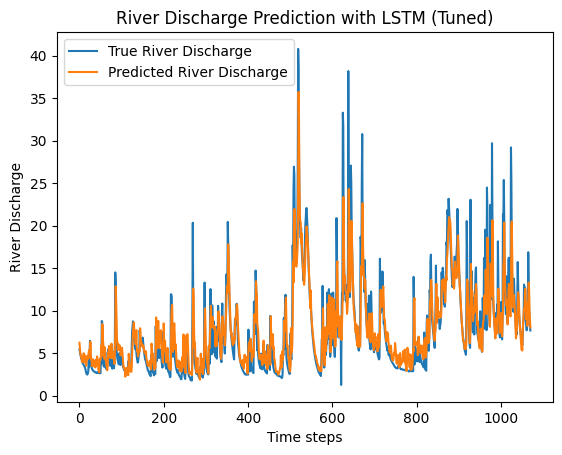

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch
from sklearn.metrics import mean_absolute_percentage_error

# Select the features for training
features = ['temperature_2m_max', 'temperature_2m_min',
            'precipitation_hours', 'wind_speed_10m_max',
            'wind_gusts_10m_max', 'river_discharge']

data = combined_df[features].values

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences and corresponding labels
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 60  # The number of previous time steps to use for prediction
X, y = create_sequences(scaled_data, time_steps)

# Split the data into training and testing sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define the model building function for hyperparameter tuning
def build_model(hp):
    model = Sequential()

    # Tune the number of units in the first LSTM layer
    model.add(LSTM(units=hp.Int('units_1', min_value=50, max_value=200, step=50),
                   return_sequences=True,
                   input_shape=(X_train.shape[1], X_train.shape[2])))

    # Tune the dropout rate for the first layer
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

    # Tune the number of units in the second LSTM layer
    model.add(LSTM(units=hp.Int('units_2', min_value=50, max_value=200, step=50)))

    # Tune the dropout rate for the second layer
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))

    # Output layer (multivariate, so use Dense with output size equal to features)
    model.add(Dense(units=X_train.shape[2]))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mean_squared_error')

    return model

# Initialize the KerasTuner RandomSearch
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of models to build and evaluate for each trial
    directory='tuning_results',
    project_name='lstm_hyperparameter_tuning'
)

# Run hyperparameter search
tuner.search(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Train the best model
best_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Predict using the best model
y_pred = best_model.predict(X_test)

# Inverse transform to get the actual values
y_test_rescaled = scaler.inverse_transform(y_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)
print(f"Test MAPE: {mape}")

# Visualize results
import matplotlib.pyplot as plt

plt.plot(y_test_rescaled[:, -1], label='True River Discharge')
plt.plot(y_pred_rescaled[:, -1], label='Predicted River Discharge')
plt.title('River Discharge Prediction with LSTM (Tuned)')
plt.xlabel('Time steps')
plt.ylabel('River Discharge')
plt.legend()
plt.show()

In [ ]:
best_model.save('my_model.h5')

# OpenAI API

In [ ]:
!pip install openai ipywidgets
!pip install openai==0.28

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.2/325.2 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.52.2
    Uninstalling openai-1.52.2:
      Successfully uninstalled openai-1.52.2


In [ ]:
import openai
import ipywidgets as widgets
from IPython.display import display

# Set your OpenAI API key
openai.api_key = YOUR_API_KEY

def get_reply(prompt):
    prompt = f"{prompt}, {combined_df}, {yesterday}"

    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=150
    )

    return response['choices'][0]['message']['content'].strip()

prompt_input = widgets.Text(
    value='',
    placeholder='Enter a prompt',
    description='data',
    disabled=False
)

output = widgets.Output()

def on_button_click(b):
    with output:
        output.clear_output()
        prompt = prompt_input.value
        reply = get_reply(prompt)
        print(f"Reply to {prompt}:\n")
        print(reply)

button = widgets.Button(
    description='Generate',
    disabled=False,
    button_style='success',
    tooltip='Click to generate',
)

button.on_click(on_button_click)

display(prompt_input, button, output)

Text(value='', description='data', placeholder='Enter a prompt')

Button(button_style='success', description='Generate', style=ButtonStyle(), tooltip='Click to generate')

Output()